<a href="https://colab.research.google.com/github/woodstone10/deep_learning_study-python/blob/main/NLP_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT (Bidirectional Encoder Representations from Transformers)

Sentiment (positive vs negative) classifier for Movie review using BERT  
---
NLP landscape:

- **RNN** (1986) - LSTM (1997) - Seq2Seq (NIPS 2014) *fixed size context vector

- **Attention** (ICLR 2015) - Transformer (NIPS 2017) - GPT-1 (2018) - BERT (NAACL 2019) - GPT-3 (2020)

---

"**Attention Is All You Need**", Google
- https://arxiv.org/pdf/1706.03762.pdf  
- You even don't need neither RNN nor CNN. It is faster by **parallelization**
- **Without RNN**, only **Attention** is all you need
- positional encoding (using sine and cos function) can enable this
- Self attention = Query (=word) * Key = attention score (=number, correlation) -> Softmax * Value (=attention layer output) 
- Which can done by parallel processing
- multi head attention
- http://jalammar.github.io/illustrated-transformer/
- residual connection followed by layer normalizaiton to combat backpropagation
- Transformer has 6 decoder layers
- decoder also use attention parallelizaiton
- At final layer, Linear and Softmax are used
- Label smoothing helped improving BLEU score and accuracy
- https://arxiv.org/pdf/1409.0473.pdf


https://github.com/NLP-kr/tensorflow-ml-nlp-tf2


## Transformer working fine on tf v2.2

In [ ]:
!pip install transformers==2.11.0
!pip install tensorflow==2.2.0

     |████████████████████████████████| 675kB 8.0MB/s 
     |████████████████████████████████| 5.6MB 10.8MB/s 
     |████████████████████████████████| 870kB 51.5MB/s 
     |████████████████████████████████| 1.2MB 49.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=ae5b51cd63c311c310ccf40d6a78f4a1c0fe70a2b44057aa26246396e7e75392
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses
     |████████████████████████████████| 516.2MB 34kB/s 
     |████████████████████████████████| 3.0MB 88kB/s 
     |████████████████████████████████| 460kB 53.0MB/s 
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing i

In [ ]:
import os
import re
import json
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from transformers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Hyper parameters

In [ ]:
tf.random.set_seed(111)
np.random.seed(111)

BATCH_SIZE = 32
NUM_EPOCHS = 3
VALID_SPLIT = 0.2
MAX_LEN = 39

## Data

---
Naver movie review (Korean)


In [ ]:
import urllib.request

train_file = urllib.request.urlopen("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt")
test_file = urllib.request.urlopen("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt")

train_data = pd.read_table(train_file)
test_data = pd.read_table(test_file)

train_data = train_data.dropna()
test_data = test_data.dropna()

In [ ]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


## BERT tokenizer

---
**Use pre-trained BERT model** 

https://github.com/google-research/bert/blob/master/multilingual.md



In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', 
                                          cache_dir='bert_ckpt',
                                          do_lower_case=False)

In [ ]:
def bert_tokenizer(sentence, MAX_LEN):
  encoded_dict = tokenizer.encode_plus(
      text = sentence,
      add_special_tokens = True,
      max_length = MAX_LEN,
      pad_to_max_length = True,
      return_attention_mask = True
  )

  input_id = encoded_dict['input_ids']
  attention_mask = encoded_dict['attention_mask']
  token_type_id = encoded_dict['token_type_ids']
  
  return input_id, attention_mask, token_type_id

## Train data

In [ ]:
input_ids = []
attention_masks = []
token_type_ids = []
train_data_lebels = []
for train_sentence, train_label in tqdm(zip(train_data['document'], train_data['label']), total=len(train_data)):
  try:
    input_id, attention_mask, token_type_id = bert_tokenizer(train_sentence, MAX_LEN)
    input_ids.append(input_id)
    attention_masks.append(attention_mask)
    token_type_ids.append(token_type_id)
    train_data_lebels.append(train_label)
  except Exception as e:
    print(e)
    pass

train_movie_input_ids = np.array(input_ids, dtype=int)
train_movie_attention_masks= np.array(attention_masks, dtype=int)
train_movie_token_type_ids = np.array(token_type_ids, dtype=int)
train_movie_inputs = (train_movie_input_ids, train_movie_attention_masks, train_movie_token_type_ids)
train_data_lebels = np.asarray(train_data_lebels, dtype=np.int32)
print("Sentences: {}\nLabels: {}".format(len(train_movie_input_ids), len(train_data_lebels)))
  

100%|██████████| 149995/149995 [00:37<00:00, 4029.62it/s]


Sentences: 149995
Labels: 149995


In [ ]:
idx=5
input_id = train_movie_input_ids[idx]
attention_mask = train_movie_attention_masks[idx]
token_type_id = train_movie_token_type_ids[idx]

print(input_id)
print(attention_mask)
print(token_type_id)
print(tokenizer.decode(input_id))

[   101   9247   8867  32158  23811    100    124  24982  17655   9757
  55511    122  23321  10954  24017  12030    129 106249  24974  30858
  18227    119    100    119    119    119   9353  30134  21789  12092
   9519 118671 119169    119    102      0      0      0      0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
[CLS] 막 걸음마 [UNK] 3세부터 초등학교 1학년생인 8살용영화. [UNK]... 별반개도 아까움. [SEP] [PAD] [PAD] [PAD] [PAD]


## BERT classifier

---
use pre-trained BERT model


In [ ]:
class TFBertClassifier(tf.keras.Model):
  def __init__(self, model_name, dir_path, num_class):
    super(TFBertClassifier, self).__init__()
    self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
    self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
    self.classifier = tf.keras.layers.Dense(num_class,
      kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range), 
      name='classifier')
  
  def call(self, inputs, attention_mask=None, toke_type_ids=None, training=False):
    outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=toke_type_ids)
    pooled_output = outputs[1]
    pooled_output = self.dropout(pooled_output, training=training)
    logits = self.classifier(pooled_output)

    return logits

In [ ]:
cls_model = TFBertClassifier(model_name='bert-base-multilingual-cased',
                             dir_path='bert_ckpt',
                             num_class=2)

## Training

In [ ]:
optimizer = tf.keras.optimizers.Adam(3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
model_name = "tf2_bert_naver_movie"
es_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=2)
checkpoint_path = os.path.join('./', model_name, 'weight.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
  print("Directory already exists\n")
else:
  os.makedirs(checkpoint_dir, exist_ok=True)
  print("{} Directory create complete\n".format(checkpoint_dir))

cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_accuracy',
                              verbose=1,
                              save_best_only=True,
                              save_weights_only=True)

./tf2_bert_naver_movie Directory create complete



In [ ]:
history = cls_model.fit(train_movie_inputs, train_data_lebels,
                        epochs=NUM_EPOCHS,
                        batch_size=BATCH_SIZE,
                        validation_split=VALID_SPLIT,
                        callbacks=[es_callback, cp_callback])

Epoch 1/3
3750/3750 [==============================] - ETA: 0s - loss: 0.4066 - accuracy: 0.8103
Epoch 00001: val_accuracy improved from -inf to 0.85009, saving model to ./tf2_bert_naver_movie/weight.h5
3750/3750 [==============================] - 1241s 331ms/step - loss: 0.4066 - accuracy: 0.8103 - val_loss: 0.3420 - val_accuracy: 0.8501
Epoch 2/3
3750/3750 [==============================] - ETA: 0s - loss: 0.3194 - accuracy: 0.8613
Epoch 00002: val_accuracy did not improve from 0.85009
3750/3750 [==============================] - 1240s 331ms/step - loss: 0.3194 - accuracy: 0.8613 - val_loss: 0.3451 - val_accuracy: 0.8499
Epoch 3/3
3750/3750 [==============================] - ETA: 0s - loss: 0.2647 - accuracy: 0.8900
Epoch 00003: val_accuracy improved from 0.85009 to 0.85553, saving model to ./tf2_bert_naver_movie/weight.h5
3750/3750 [==============================] - 1241s 331ms/step - loss: 0.2647 - accuracy: 0.8900 - val_loss: 0.3473 - val_accuracy: 0.8555


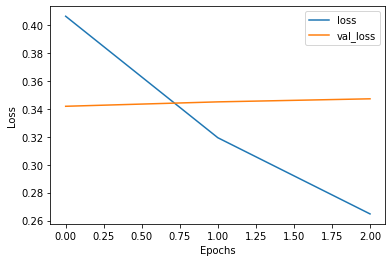

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

## Test data

In [ ]:
input_ids = []
attention_masks = []
token_type_ids = []
test_data_labels = []
for test_sentence, test_label in tqdm(zip(test_data['document'], test_data['label'])):
  try:
    input_id, attention_mask, token_type_id = bert_tokenizer(test_sentence, MAX_LEN)
    input_ids.append(input_id)
    attention_masks.append(attention_mask)
    token_type_ids.append(token_type_id)
    test_data_labels.append(test_label)
  except Exception as e:
    print(e)
    pass


0it [00:00, ?it/s]
413it [00:00, 4128.87it/s]
812it [00:00, 4079.15it/s]
1208it [00:00, 4040.61it/s]
1621it [00:00, 4065.46it/s]
2019it [00:00, 4035.96it/s]
2442it [00:00, 4090.13it/s]
2818it [00:00, 3985.11it/s]
3225it [00:00, 4007.59it/s]
3638it [00:00, 4043.27it/s]
4027it [00:01, 3923.84it/s]
4461it [00:01, 4039.55it/s]
4867it [00:01, 4041.89it/s]
5284it [00:01, 4078.83it/s]
5689it [00:01, 4022.30it/s]
6090it [00:01, 3959.81it/s]
6485it [00:01, 3877.30it/s]
6873it [00:01, 3867.16it/s]
7260it [00:01, 3843.31it/s]
7652it [00:01, 3864.41it/s]
8039it [00:02, 3822.53it/s]
8422it [00:02, 3785.64it/s]
8809it [00:02, 2270.48it/s]
9183it [00:02, 2573.27it/s]
9590it [00:02, 2892.10it/s]
10004it [00:02, 3178.76it/s]
10391it [00:02, 3355.59it/s]
10778it [00:02, 3494.03it/s]
11175it [00:03, 3624.28it/s]
11558it [00:03, 3675.12it/s]
11990it [00:03, 3846.89it/s]
12387it [00:03, 3852.64it/s]
12781it [00:03, 3829.29it/s]
13176it [00:03, 3864.55it/s]
13567it [00:03, 3798.32it/s]
13951it [00:03, 3659

In [ ]:
test_movie_input_ids = np.array(input_ids, dtype=int)
test_movie_attention_masks= np.array(attention_masks, dtype=int)
test_movie_token_type_ids = np.array(token_type_ids, dtype=int)
test_movie_inputs = (test_movie_input_ids, test_movie_attention_masks, test_movie_token_type_ids)  
test_data_labels = np.asarray(test_data_labels, dtype=np.int32)

## Evaluation

In [ ]:
cls_model.evaluate(test_movie_inputs, test_data_labels, batch_size=1024)

49/49 [==============================] - 128s 3s/step - loss: 0.3546 - accuracy: 0.8515


[0.35462212562561035, 0.8514510989189148]